## Time-resolved single-gene analyses

### 1 Prepare data

Write part of the directory listing to a variable:

In [1]:
import platform

files = !ls ../results/volume*

Set up a dictionary that contains the simulation results.

In [2]:
import re

filepaths = {}
for file in files:
    match = re.search(r'from (\w+)', file)
    if match:
        filepaths[int(match.group(1).zfill(4))] = file

Function to replace _numpypy.multiarray by numpy.core.multiarray. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [3]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

Port from Pypy to Python:

In [4]:
for time in filepaths:
    print time,
    #replace(filepaths[time], "_numpypy.multiarray", "numpy.core.multiarray")

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


In [5]:
import cPickle as pkl

results = {}
proteome = {}
for time in filepaths:
    print time, filepaths[time]
    results[time] = pkl.load(open(filepaths[time]))
    proteome[time] = {key: results[time]['proteome'][key] for key in results[time]['proteome'] 
                     if results[time]['proteome'][key] > 1e-2}

0 ../results/volume-adjusted polyphasic cell cycle from 0 to 300, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160804_1452_1200s.p
2400 ../results/volume-adjusted polyphasic cell cycle from 2400 to 2700, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160804_1741_1200s.p
3300 ../results/volume-adjusted polyphasic cell cycle from 3300 to 3600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160804_1845_1200s.p
1800 ../results/volume-adjusted polyphasic cell cycle from 1800 to 2100, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160804_1655_1200s.p
300 ../results/volume-adjusted polyphasic cell cycle from 300 to 600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Sh

### 2 Test burn-in period

Plot timecourses:

In [6]:
import numpy as np
import random

time = 300  # any cell cycle time shuld be tested in theory
protnames = results[time]['timecourses'].keys()
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

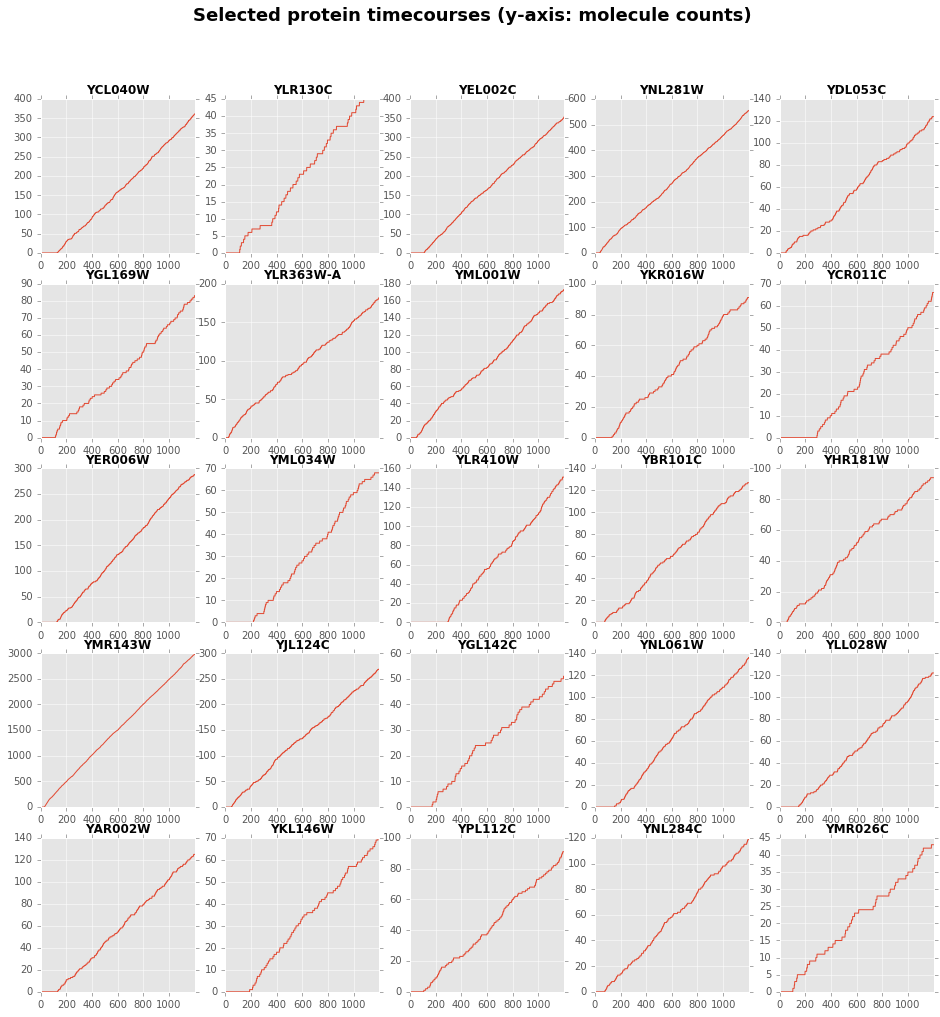

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

fig, ax = plt.subplots(size, size, figsize=(16, 16))

plt.suptitle('Selected protein timecourses (y-axis: molecule counts)', fontsize=18, fontweight='bold')

for i in range(size):
    for j in range(size):
        yseries = results[time]['timecourses'][protnames_plot[i][j]]
        xseries = np.arange(0., float(len(yseries)), 1.)
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 200.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)

### 3 Single-gene analysis

In [8]:
genes_shortlist = {'HHF1': 'YBR009C', 'HHF2': 'YNL030W', 'HHT1': 'YBR010W', 'HHT2': 'YNL031C', 'HTB1': 'YDR224C', 
                   'HTB2': 'YBL002W', # 'PMA1': 'YGL008C', 
                   # 'RNR1': 'YER070W', 'RNR2': 'YJL026W', 'RNR3': 'YIL066C', 'RNR4': 'YGR180C', 
                   # genes suggested by Katja, some histones
                   'SIC1': 'YLR079W', 'CLN2': 'YPL256C', 'CLB2': 'YPR119W', 'CLB5': 'YPR120C', 
                   'PCL1': 'YNL289W', 'PCL9': 'YDL179W', 'SWE1': 'YJL187C'} # FISH genes

In [9]:
translation_rate_shortlist = {}

for (genecommon, gene) in genes_shortlist.items():
    translation_rate_shortlist[genecommon] = []
    for time in np.arange(0, 3600, 300):
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-601])/600.
        else:
            rate = 0.
        translation_rate_shortlist[genecommon].append(rate)

In [10]:
import pandas as pd

translation_ratedf = pd.DataFrame(translation_rate_shortlist, index=np.arange(0, 3600, 300))

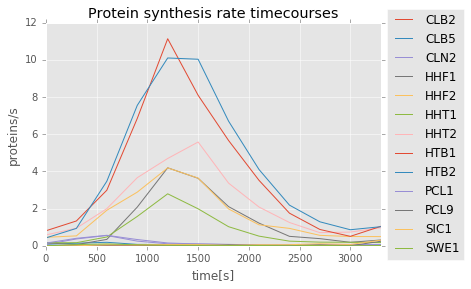

In [11]:
pl = translation_ratedf.plot(title="Protein synthesis rate timecourses")

pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.set_xlabel("time[s]")
pl.set_ylabel("proteins/s")

For these genes, find mRNA time courses:

In [12]:
import collections

transcriptomes_dict = collections.OrderedDict(sorted(
        pkl.load((open('../parameters/transcriptome_time_dependent.p'))).items()))

In [13]:
transcriptomes_df = pd.DataFrame(transcriptomes_dict).transpose()

In [14]:
transcriptomes_df.set_index(np.arange(0, 3601, 300), inplace=True)

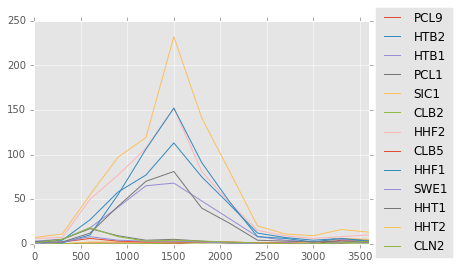

In [15]:
transcriptomes_short_df = transcriptomes_df[genes_shortlist.values()]
transcriptomes_short_df.columns = genes_shortlist.keys()
transcriptomes_short_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [16]:
transcriptomes_short_df = transcriptomes_short_df[['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 
                                                   #'HHF1', 'HHF2', 'HHT1', 'HHT2', # no initiation rates
                                                   'HTB1', 'HTB2']]
transcriptomes_short_df

,CLB2,CLB5,CLN2,PCL1,PCL9,SIC1,SWE1,HTB1,HTB2
0,0,1,1,2,0,0,0,3,2
300,0,2,5,5,0,0,2,5,4
600,0,6,18,17,1,2,8,18,27
900,0,3,8,9,1,2,4,41,58
1200,0,2,3,4,1,2,3,65,77
1500,1,2,4,5,0,3,3,68,113
1800,1,2,3,3,2,1,2,48,75
2100,1,2,2,1,1,2,1,28,44
2400,0,1,1,0,0,1,0,8,12
2700,0,1,0,1,1,2,1,4,7


In [17]:
translation_ratedf

,CLB2,CLB5,CLN2,HHF1,HHF2,HHT1,HHT2,HTB1,HTB2,PCL1,PCL9,SIC1,SWE1
0,0.000000,0.085000,0.070000,0.163333,0.456667,0.165000,0.583333,0.808333,0.425000,0.146667,0.000000,0.000000,0.000000
300,0.000000,0.136667,0.368333,0.063333,0.533333,0.166667,0.946667,1.335000,0.935000,0.403333,0.000000,0.000000,0.063333
600,0.000000,0.188333,0.553333,0.343333,1.910000,0.473333,1.996667,2.988333,3.470000,0.565000,0.038333,0.056667,0.101667
900,0.000000,0.075000,0.251667,2.080000,2.885000,1.578333,3.661667,6.846667,7.550000,0.336667,0.045000,0.055000,0.055000
1200,0.000000,0.068333,0.106667,4.193333,4.188333,2.795000,4.695000,11.131667,10.098333,0.151667,0.041667,0.071667,0.025000
1500,0.021667,0.030000,0.103333,3.630000,3.640000,1.988333,5.580000,8.091667,10.030000,0.095000,0.000000,0.066667,0.025000
1800,0.020000,0.033333,0.076667,2.106667,1.981667,1.026667,3.370000,5.661667,6.701667,0.065000,0.060000,0.025000,0.020000
2100,0.016667,0.046667,0.048333,1.220000,1.128333,0.520000,2.085000,3.520000,4.103333,0.020000,0.030000,0.056667,0.015000
2400,0.000000,0.050000,0.048333,0.508333,0.936667,0.250000,1.253333,1.755000,2.186667,0.000000,0.000000,0.060000,0.000000
2700,0.000000,0.058333,0.000000,0.385000,0.561667,0.196667,0.706667,0.878333,1.290000,0.055000,0.058333,0.108333,0.021667


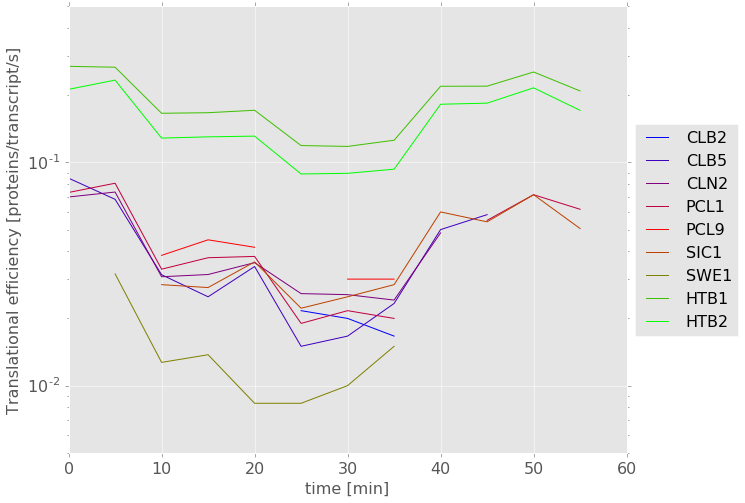

In [18]:
plt.rcParams['figure.figsize'] = (10, 8)

ratio = translation_ratedf.div(transcriptomes_short_df)[['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 
                                                         #'HHF1', 'HHF2', 'HHT1', 'HHT2', 
                                                         'HTB1', 'HTB2']]
ratio.set_index(np.arange(0, 61, 5), inplace=True)
ax = ratio.plot(logy=True, ylim=[5e-3, 5e-1], colormap='brg')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
ax.set_xlabel("time [min]", fontsize=16)
ax.set_ylabel("Translational efficiency [proteins/transcript/s]", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

In [19]:
init_rates = pkl.load(open("../parameters/init_rates_plotkin.p", "rb"))

In [20]:
for gene in ['CLB2', 'CLB5', 'CLN2', 'PCL1', 'PCL9', 'SIC1', 'SWE1', 'HHF1', 'HHF2', 'HHT1', 'HHT2', 'HTB1', 
             'HTB2']:
    if genes_shortlist[gene] in init_rates:
        print gene, genes_shortlist[gene], init_rates[genes_shortlist[gene]]

CLB2 YPR119W 1.07863479792e-06
CLB5 YPR120C 1.08393456684e-06
CLN2 YPL256C 1.07536488822e-06
PCL1 YNL289W 1.27382287498e-06
PCL9 YDL179W 1.42121527966e-06
SIC1 YLR079W 1.15695247462e-06
SWE1 YJL187C 3.75113962529e-07
HTB1 YDR224C 8.58045121193e-06
HTB2 YBL002W 5.73892764002e-06


### 4 Time-resolved translational efficiencies csv

In [26]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
all_genes = orf_genomic_dict.keys()

In [27]:
translation_rate_full = {}

for time in np.arange(0, 3600, 300):
    for gene in all_genes:
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-601])/600.
            translation_rate_full.setdefault(gene, []).append(rate)
        else:
            translation_rate_full.setdefault(gene, []).append(0.0)

In [28]:
translation_rate_full_df = pd.DataFrame(translation_rate_full, index=np.arange(0, 3600, 300))

In [30]:
translation_rate_full_df

,Q0010,Q0017,Q0032,Q0045,Q0050,Q0055,Q0060,Q0065,Q0070,Q0075,...,YPR196W,YPR197C,YPR198W,YPR199C,YPR200C,YPR201W,YPR202W,YPR203W,YPR204C-A,YPR204W
0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0.000000,0.000000,0.000000,0,0,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0.000000,0.000000,0.000000,0,0,0,0,0
600,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0.033333,0.000000,0.035000,0,0,0,0,0
900,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0.061667,0.010000,0.000000,0,0,0,0,0
1200,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0.041667,0.016667,0.023333,0,0,0,0,0
1500,0,0,0,0,0,0,0,0,0,0,...,0.013333,0,0.043333,0.005000,0.000000,0,0,0,0,0
1800,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0.060000,0.015000,0.000000,0,0,0,0,0
2100,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0.040000,0.011667,0.000000,0,0,0,0,0
2400,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0.046667,0.016667,0.000000,0,0,0,0,0
2700,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0.056667,0.038333,0.000000,0,0,0,0,0


In [33]:
te = translation_rate_full_df.div(transcriptomes_df)

In [37]:
te = te.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [38]:
te

,YAL001C,YAL002W,YAL003W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,...,YPR187W,YPR188C,YPR189W,YPR190C,YPR191W,YPR192W,YPR196W,YPR198W,YPR199C,YPR200C
0,NaN,0.036667,0.243922,0.082800,0.110000,0.145000,0.050000,NaN,NaN,0.195714,...,0.135333,0.103333,0.070000,0.088333,0.108333,NaN,NaN,NaN,NaN,NaN
300,0.046667,NaN,0.247308,0.088478,0.130000,0.143333,NaN,NaN,NaN,0.197807,...,0.143750,0.100000,0.085000,0.080000,0.103333,NaN,NaN,NaN,NaN,NaN
600,0.015000,0.005000,0.131910,0.035995,0.053056,0.072917,0.021667,NaN,0.018333,0.105385,...,0.065769,0.040000,0.021667,0.030833,0.055833,NaN,NaN,0.033333,NaN,0.035000
900,0.031667,0.008333,0.136601,0.038298,0.053333,0.081667,0.025000,0.028333,0.037500,0.111120,...,0.063590,0.053333,0.035833,0.033333,0.055000,NaN,NaN,0.030833,0.010000,NaN
1200,0.020000,0.006667,0.136797,0.039533,0.058667,0.080000,0.020000,NaN,0.023333,0.110091,...,0.068222,0.051111,0.031667,0.034333,0.063333,NaN,NaN,0.041667,0.016667,0.023333
1500,0.013333,0.006667,0.093983,0.024317,0.036458,0.045833,0.014722,NaN,0.015000,0.073971,...,0.043095,0.027083,0.021667,0.021667,0.041111,0.023333,0.013333,0.021667,0.005000,NaN
1800,0.012500,0.006667,0.093200,0.023763,0.034375,0.045000,0.012333,0.016667,0.022500,0.074475,...,0.043796,0.032778,0.021250,0.021667,0.035833,NaN,NaN,0.030000,0.007500,NaN
2100,0.018333,0.006667,0.095417,0.025101,0.035417,0.053333,0.014167,0.016667,0.021667,0.074500,...,0.044921,0.031111,0.025000,0.019524,0.027778,NaN,NaN,0.020000,0.011667,NaN
2400,0.033333,0.041667,0.188827,0.061301,0.080833,0.106667,0.040556,NaN,NaN,0.155303,...,0.097576,0.073333,0.059167,0.046667,0.071667,NaN,NaN,0.046667,0.016667,NaN
2700,0.046667,0.021667,0.185319,0.060539,0.081667,0.120000,0.043333,NaN,0.031667,0.150976,...,0.095303,0.084167,0.061667,0.052500,0.084167,NaN,NaN,0.056667,0.038333,NaN


In [42]:
import csv

with open('../results/init_rates.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['gene', 'rate'])
    for key, value in init_rates.items():
        writer.writerow([key, value])

In [43]:
te.to_csv('../results/te_time-resolved.csv')